Mental health sentiment analysis presents a fascinating challenge in the field of Natural Language Processing (NLP). Our project aims to leverage machine learning techniques to classify text into distinct mental health categories, offering potential insights for early intervention and support.

We are focusing on seven key classifications: Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, and Personality Disorder. By analyzing textual data, we hope to uncover linguistic patterns and emotional markers that correlate with these mental health states.

The potential benefits of this project are significant. By developing accurate classification models, we can provide mental health professionals with an additional screening tool, potentially enabling earlier detection of mental health issues. This could lead to more timely interventions and improved patient outcomes. Moreover, the insights gained from our models could enhance our understanding of how language use reflects mental states, contributing to the broader field of mental health research.

# 1. Importing libraries

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import string
import random
from imblearn.over_sampling import SMOTE, RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# 2. Loading Data

In [3]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv', index_col=0)

df1 = df.copy() 
df1.dropna(inplace = True)
df1.head() 

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df1.shape

(52681, 2)

In [5]:
df1['statement_len'] = df1['statement'].apply(lambda x: len(x.split(' ')))
df1.head() 

,statement,status,statement_len
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14
3,I've shifted my focus to something else but I'...,Anxiety,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14


In [6]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   statement      52681 non-null  object
 1   status         52681 non-null  object
 2   statement_len  52681 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB
None


In [7]:
df1.describe(include='object').T

,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,52681,7,Normal,16343


# 2.EDA

Now we are going to take a look at the target distribution

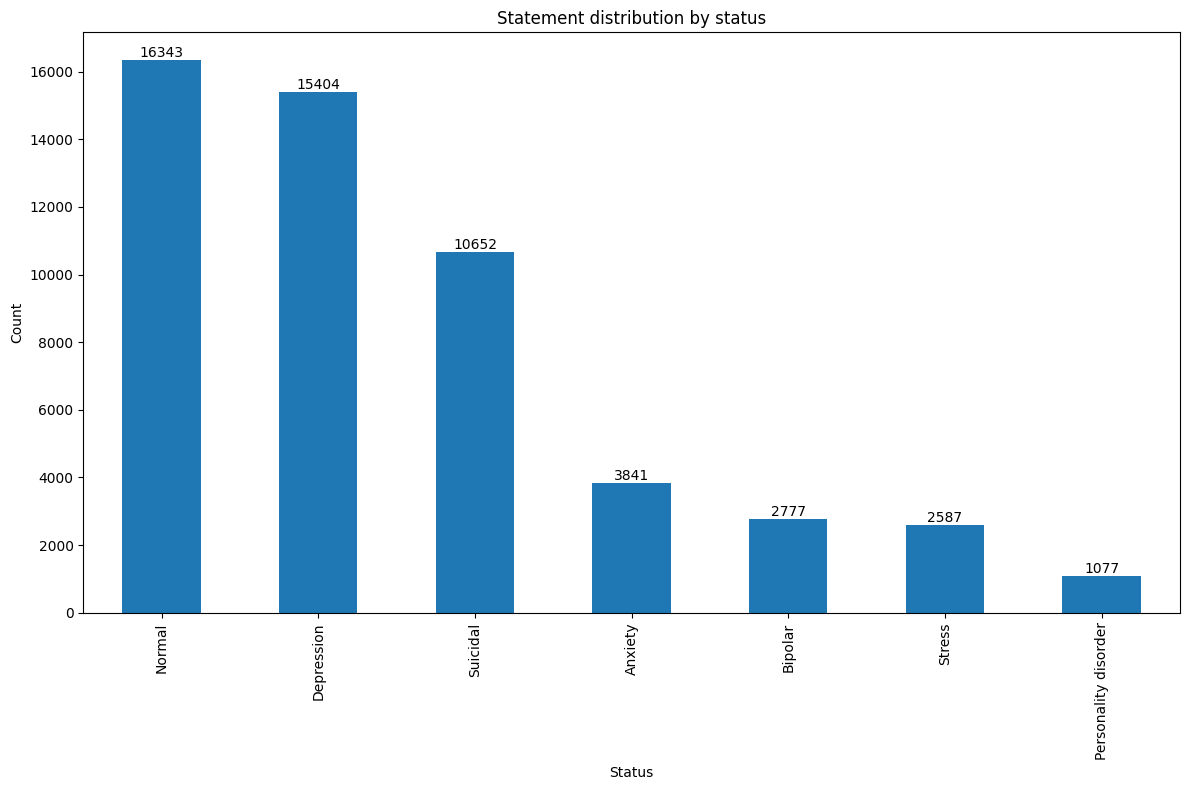

In [8]:
plt.figure(figsize=(12,8))

# get the unique status values and their counts
status_counts = df1['status'].value_counts()

# create the bar plot
ax = status_counts.plot(kind='bar')

# add the count labels on top of each bar
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show() 

As we can see, the classes are imbalanced, so we can consider using some kind of resampling. We will study this later.

# Data Pre-processing

Now we are going to engineering the data to make it easier for the model to clasiffy.

This section is very important to reduce the dimensions of the problem.

In [9]:
# Cleaning the corpus

def clean_text(text):
    '''
    Comprehensively clean text by making it lowercase, removing various patterns,
    links, punctuation, and words containing numbers.
    '''
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove URLs (including markdown-style links)
    text = re.sub(r'https?://\S+|www\.\S+|\[.*?\]\(.*?\)', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)
    
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    
    # Remove punctuation and other special characters
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
    # Remove newline characters
    text = re.sub(r'\n', ' ', text)
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [10]:
df2 = df1.copy()

df2['statement_clean'] = df2['statement'].apply(clean_text)
df2.head() 

,statement,status,statement_len,statement_clean
0,oh my gosh,Anxiety,3,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,11,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,im restless and restless its been a month now ...


**Stopwords:**

Stopwords are commonly used words in English which have no contextual meaning in an sentence. Examples of stopwords include:
1. Articles: a, an, the
2. Prepositions: in, on, at, to, for, of, with
3. Pronouns: I, you, he, she, it, we, they, them
4. Conjunctions: and, but, or, so, because
5. Auxiliary verbs: is, am, are, was, were, be, been, have, has, had
6. Common adverbs: very, really, too, also, just
7. Common adjectives: many, much, few, more, most, some, any
8. Others: this, that, these, those, there, here

In [11]:
stop_words = stopwords.words('english') 
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df2['statement_clean'] = df2['statement_clean'].apply(remove_stopwords)
df2.head() 

,statement,status,statement_len,statement_clean
0,oh my gosh,Anxiety,3,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,11,ive shifted focus something else still worried
4,"I'm restless and restless, it's been a month n...",Anxiety,14,restless restless month boy mean


**Stemming/ Lematization**

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word. As far as the meaning of the words is important for this study, we are meant to focus on lemmatization rather than stemming, but for its simplicity we will use stemming. 

In [12]:
stemmer = nltk.SnowballStemmer("english")
# stemmer = nltk.PorterStemmer()

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [13]:
df2['statement_clean'] = df2['statement_clean'].apply(stemm_text) 
df2.head() 

,statement,status,statement_len,statement_clean
0,oh my gosh,Anxiety,3,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,troubl sleep confus mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,11,ive shift focus someth els still worri
4,"I'm restless and restless, it's been a month n...",Anxiety,14,restless restless month boy mean


**All together**

In [14]:
def preprocess_data(text):
    #Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    
    return text 

In [15]:
df2['statement_clean'] = df2['statement_clean'].apply(preprocess_data)
df2.head()

,statement,status,statement_len,statement_clean
0,oh my gosh,Anxiety,3,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,troubl sleep confus mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,Anxiety,11,ive shift focus someth el still worri
4,"I'm restless and restless, it's been a month n...",Anxiety,14,restless restless month boy mean


**Target Encoding**

In [16]:
from sklearn.preprocessing import LabelEncoder

l_encoder = LabelEncoder()
l_encoder.fit(df2['status'])

df2['status_encoded'] = l_encoder.transform(df2['status']) 
df2.head() 

,statement,status,statement_len,statement_clean,status_encoded
0,oh my gosh,Anxiety,3,oh gosh,0
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,troubl sleep confus mind restless heart tune,0
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,wrong back dear forward doubt stay restless re...,0
3,I've shifted my focus to something else but I'...,Anxiety,11,ive shift focus someth el still worri,0
4,"I'm restless and restless, it's been a month n...",Anxiety,14,restless restless month boy mean,0


# Tokens Visualization

In [17]:
df2['tokens'] = df2['statement_clean'].apply(word_tokenize)
df2.head()

,statement,status,statement_len,statement_clean,status_encoded,tokens
0,oh my gosh,Anxiety,3,oh gosh,0,"[oh, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,troubl sleep confus mind restless heart tune,0,"[troubl, sleep, confus, mind, restless, heart,..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,wrong back dear forward doubt stay restless re...,0,"[wrong, back, dear, forward, doubt, stay, rest..."
3,I've shifted my focus to something else but I'...,Anxiety,11,ive shift focus someth el still worri,0,"[ive, shift, focus, someth, el, still, worri]"
4,"I'm restless and restless, it's been a month n...",Anxiety,14,restless restless month boy mean,0,"[restless, restless, month, boy, mean]"


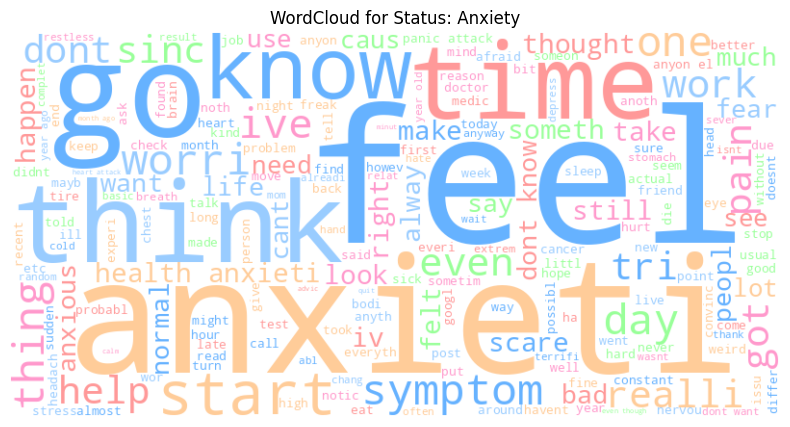

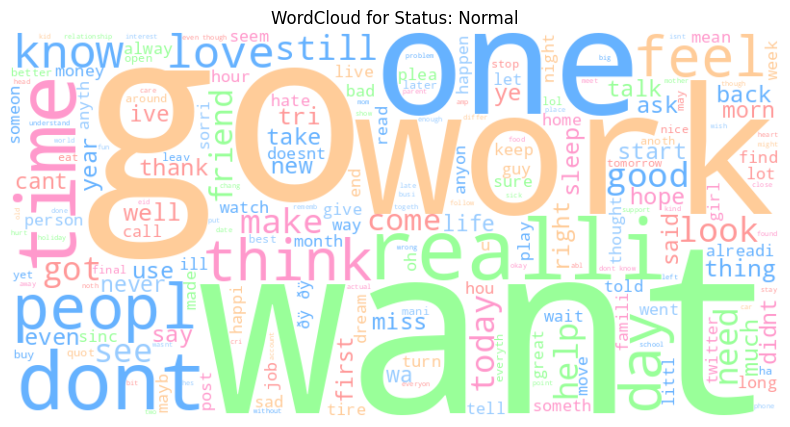

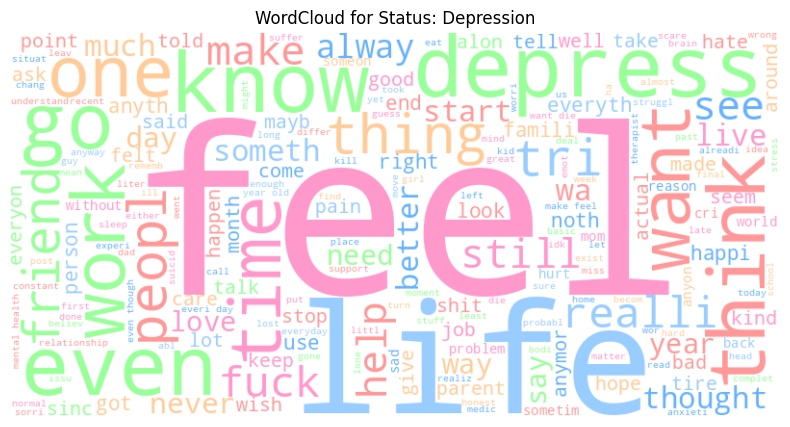

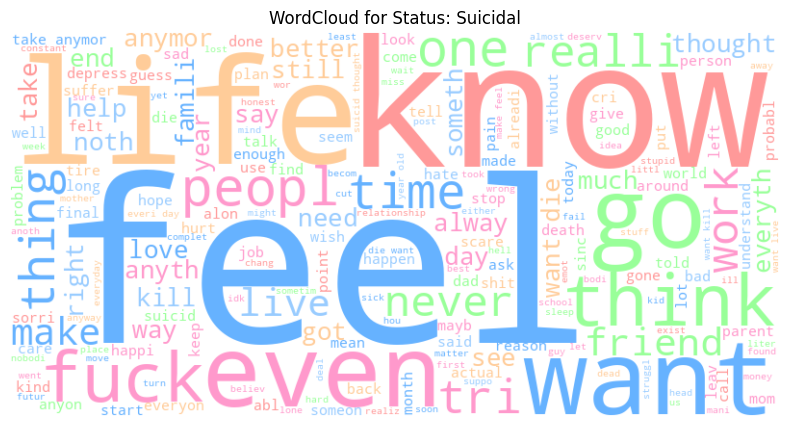

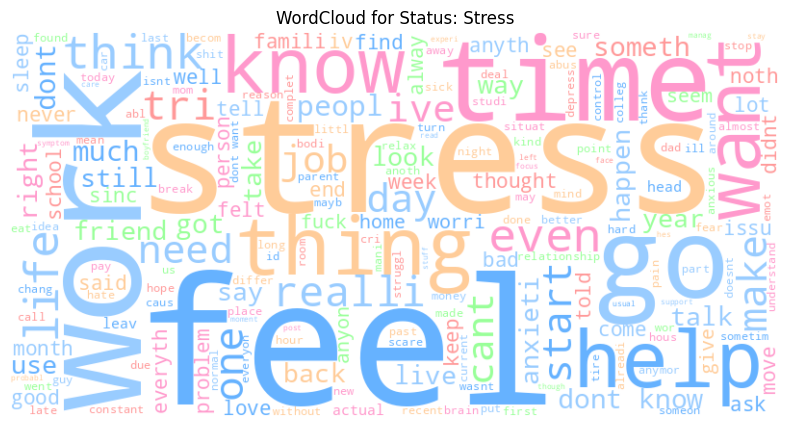

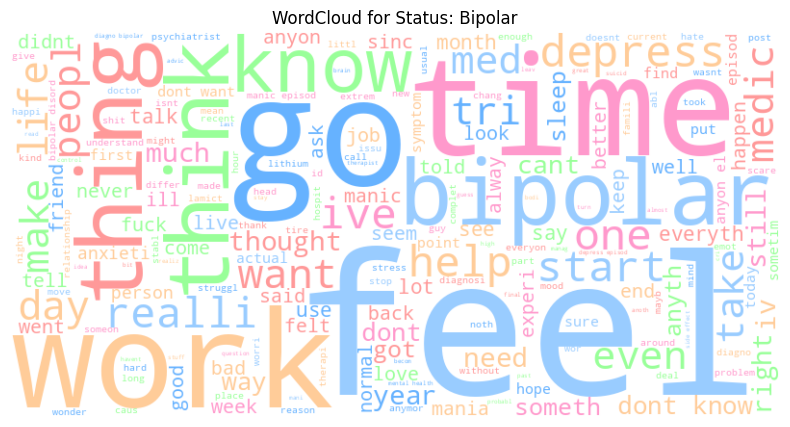

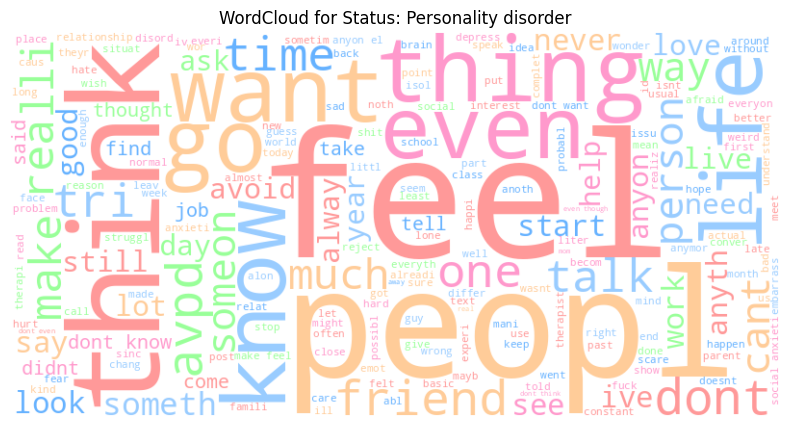

In [18]:
# Get unique categories in 'status'
statuses = df2['status'].unique()

# Define a list of colors
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF']

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df2[df2['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

# Vectorization

Currently, we have the messages as lists of tokens (also known as lemmas) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

In [19]:
#df2

In [20]:
# define X and y for use with COUNTVECTORIZER
X = df2['statement_clean']
y = df2['status_encoded']

print(len(X), len(y)) 

52681 52681


In [21]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))   

47412 47412
5269 5269


In [22]:
# instantiate the vectorizer
c_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_df=0.7, max_features=50_000)
c_vectorizer.fit(X_train) 

CountVectorizer(max_df=0.7, max_features=50000, ngram_range=(1, 2),
                stop_words='english')

In [23]:
# Use the trained to create a document-term matrix from train and test sets
X_train_dtm = c_vectorizer.transform(X_train)
X_test_dtm = c_vectorizer.transform(X_test) 

**TF-IDF (Term Frequency–Inverse Document Frequency)**

In [24]:
#tfidf_vectorizer = TfidfVectorizer(max_features= 50_000, ngram_range=(1, 2))

#tfidf_vectorizer.fit(X_train)
#X_train_tfidf = tfidf_vectorizer.transform(X_train)
#X_test_tfidf = tfidf_vectorizer.transform(X_test)

#X_train_tfidf 

In [25]:
texts = df2['statement_clean']
target = df2['status_encoded'] 

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

58126

**Addressing Class Imbalance**

In [27]:
r_oversampler = RandomOverSampler(random_state= 42) 
X_train_resampled, y_train_resampled = r_oversampler.fit_resample(X_train_dtm, y_train) 

In [28]:
#r_oversampler = RandomOverSampler(random_state=42)
#X_train_resampled2, y_train_resampled2 = r_oversampler.fit_resample(X_train_tfidf, y_train) 

In [29]:
print((X_train_resampled.shape), (y_train_resampled.shape))

(102816, 50000) (102816,)


# Modelling

In [30]:
lr_clf = LogisticRegression(random_state= 42) 

# Train the classifier
lr_clf.fit(X_train_resampled, y_train_resampled)

LogisticRegression(random_state=42)

In [31]:
y_pred = lr_clf.predict(X_test_dtm)
labels = l_encoder.classes_
conf_matrix = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=labels)) 

                      precision    recall  f1-score   support

             Anxiety       0.81      0.82      0.82       371
             Bipolar       0.85      0.80      0.82       273
          Depression       0.72      0.67      0.69      1521
              Normal       0.89      0.94      0.91      1655
Personality disorder       0.78      0.68      0.73       114
              Stress       0.62      0.59      0.61       258
            Suicidal       0.63      0.65      0.64      1077

            accuracy                           0.76      5269
           macro avg       0.76      0.74      0.75      5269
        weighted avg       0.76      0.76      0.76      5269



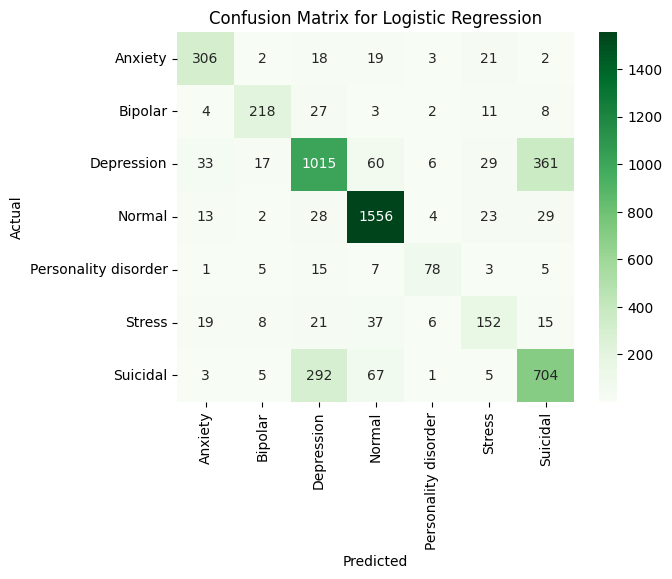

In [32]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [33]:
#rf_clf = RandomForestClassifier(random_state=42, n_estimators=500)
#rf_clf.fit(X_train_resampled, y_train_resampled)

In [34]:
#y_pred2 = rf_clf.predict(X_test_dtm)
#labels = l_encoder.classes_
#conf_matrix2 = confusion_matrix(y_test, y_pred2)
#print(classification_report(y_test, y_pred2, target_names=labels))

In [35]:
#sns.heatmap(conf_matrix2, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
#plt.xlabel('Predicted')
#plt.ylabel('Actual')
#plt.title('Confusion Matrix RandomForestClassifier')
#plt.show()

In [36]:
xgb_clf = XGBClassifier(n_estimators= 1_000, learning_rate=0.05, tree_method='gpu_hist') 
xgb_clf.fit(X_train_resampled, y_train_resampled, 
             early_stopping_rounds=5, 
             eval_set=[(X_test_dtm, y_test)], 
             verbose=False) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [37]:
y_pred3 = xgb_clf.predict(X_test_dtm)

labels3 = l_encoder.classes_
conf_matrix3 = confusion_matrix(y_test, y_pred3)
print(classification_report(y_test, y_pred3, target_names=labels3))

                      precision    recall  f1-score   support

             Anxiety       0.80      0.83      0.82       371
             Bipolar       0.82      0.86      0.84       273
          Depression       0.79      0.64      0.71      1521
              Normal       0.87      0.93      0.90      1655
Personality disorder       0.65      0.78      0.71       114
              Stress       0.58      0.68      0.62       258
            Suicidal       0.66      0.71      0.69      1077

            accuracy                           0.78      5269
           macro avg       0.74      0.78      0.76      5269
        weighted avg       0.78      0.78      0.77      5269



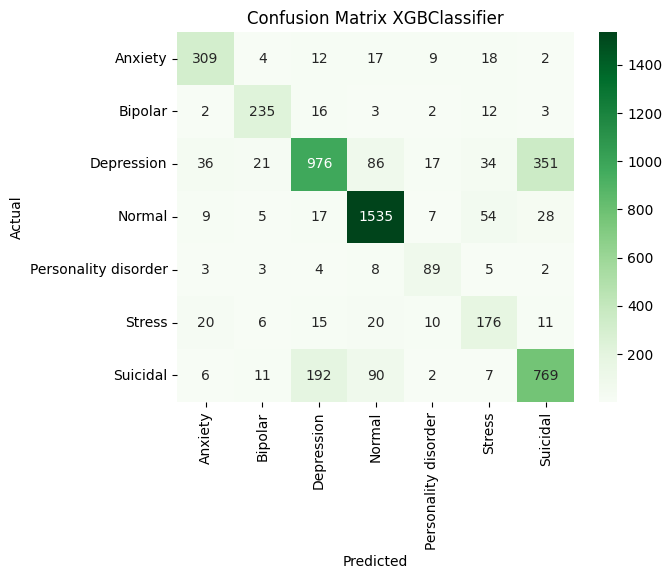

In [38]:
sns.heatmap(conf_matrix3, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels3)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix XGBClassifier')
plt.show()

Thank you for exploring this notebook! If you found value in the content, please consider giving it an upvote ⬆️. Your support means a lot to me and encourages me to create more helpful notebooks.